**Matrix Analysis and Visualization**

This script performs matrix analysis for different values of  k  (number of signatures) and visualizes key metrics to evaluate the quality of matrix decomposition.

***Overview***

The script analyzes a given input matrix  M  using Non-Negative Matrix Factorization (NMF) and evaluates the decomposition through the following metrics:

	1.	Mean Cosine Similarity: Measures alignment between the columns of  W .
	2.	Log-Likelihood (Poisson): Assesses how well the reconstructed matrix approximates the original  M .
	3.	Earth Mover’s Distance (EMD): Quantifies distributional similarity between rows of  W .

These metrics are plotted against the values of  k , along with their standard deviations, for better interpretability.

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

In [24]:
def perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations, k_values, verbose=True):
    """
    Perform matrix analysis, normalize metrics, and compute a comprehensive measure
    that combines normalized cosine similarity, log-likelihood, and EMD.

    Parameters:
    ----------
    - M_path: str
        Path to the input matrix M (e.g., gene expression matrix).
    - decomposed_matrices_folder: str
        Path to the folder containing the decomposed matrices (W and H).
    - iterations: int
        Number of iterations for the NMF decomposition.
    - k_values: list
        List of values for the number of signatures (k) to analyze.
    - verbose: bool
        Whether to print progress information.
    """
    def compute_log_likelihood_poisson(M, reconstructed_M):
        return np.sum(M * np.log(reconstructed_M + 1e-10) - reconstructed_M)

    def normalize(values):

        min_val, max_val = min(values), max(values)
        return [
            2 * (v - min_val) / (max_val - min_val) - 1 if max_val > min_val else 0
            for v in values
        ]

    # Load and normalize the input matrix M
    M = pd.read_csv(M_path).iloc[:, 1:].values.astype(float)
    M /= M.sum(axis=0, keepdims=True)

    mean_cosine_similarities, mean_log_likelihoods, mean_emd_values = {}, {}, {}

    for k in k_values:
        if verbose:
            print(f"Analyzing k={k}...")
        cosine_sim_matrices, log_liks, emd_matrices = [], [], []

        for rep in range(1, iterations + 1):
            W_path = f"{decomposed_matrices_folder}/D_k{k}_run{rep}.csv"
            H_path = f"{decomposed_matrices_folder}/lambda_k{k}_run{rep}.csv"

            if not os.path.exists(W_path) or not os.path.exists(H_path):
                continue

            # Load W and H matrices
            W = pd.read_csv(W_path, header=None).values
            H = pd.read_csv(H_path, header=None).values
            
            W /= W.sum(axis=0, keepdims=True)  # Normalize columns of W

            # Compute log-likelihood
            reconstructed_M = np.dot(W, H)
            log_liks.append(compute_log_likelihood_poisson(M, reconstructed_M))

            # Compute cosine similarity between columns of W
            col_cosine_sim = -cosine_similarity(W.T)
            cosine_sim_matrices.append(np.mean(col_cosine_sim))

            # Compute pairwise EMD between columns of W
            n_cols = W.shape[1]
            emd_matrix = np.zeros((n_cols, n_cols))
            for i in range(n_cols):
                for j in range(n_cols):
                    emd_matrix[i, j] = wasserstein_distance(W[:, i], W[:, j])
            emd_matrices.append(np.mean(emd_matrix))

        # Store mean values for each k
        if cosine_sim_matrices:
            mean_cosine_similarities[k] = np.mean(cosine_sim_matrices)
        if log_liks:
            mean_log_likelihoods[k] = np.mean(log_liks)
        if emd_matrices:
            mean_emd_values[k] = np.mean(emd_matrices)

    # Normalize all metrics
    ks = list(mean_cosine_similarities.keys())
    normalized_cosine = normalize([mean_cosine_similarities[k] for k in ks])
    normalized_log_likelihood = normalize([mean_log_likelihoods[k] for k in ks])
    normalized_emd = normalize([mean_emd_values[k] for k in ks])

    # Compute comprehensive measure as a weighted sum
    comprehensive_measure = [
        0.5 * cosine + 0.3 * log_likelihood + 0.2 * (1 - emd)  # Assuming weights for each metric
        for cosine, log_likelihood, emd in zip(normalized_cosine, normalized_log_likelihood, normalized_emd)
    ]

    # Plot results
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot Normalized Cosine Similarity
    ax1.plot(ks, normalized_cosine, 'o-', color='blue', label='Normalized Cosine Similarity')
    ax1.set_xlabel('Number of Signatures (k)')
    ax1.set_ylabel('Normalized Metrics', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot Normalized Log-Likelihood
    ax1.plot(ks, normalized_log_likelihood, 's-', color='green', label='Normalized Log-Likelihood')

    # Plot Normalized EMD (inverted for compatibility)
    ax1.plot(ks, [1 - e for e in normalized_emd], '^-', color='red', label='Normalized EMD (1 - EMD)')

    # Plot Comprehensive Measure
    ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')

    # Add Title, Grid, and Legend
    ax1.grid(True)
    plt.title('Normalized Metrics and Comprehensive Measure vs. Number of Signatures')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")

    plt.tight_layout()
    plt.show()

/var/folders/n7/mscr753j2cv6tdsjb7n5q4kr0000gn/T/ipykernel_49915/1448134245.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')


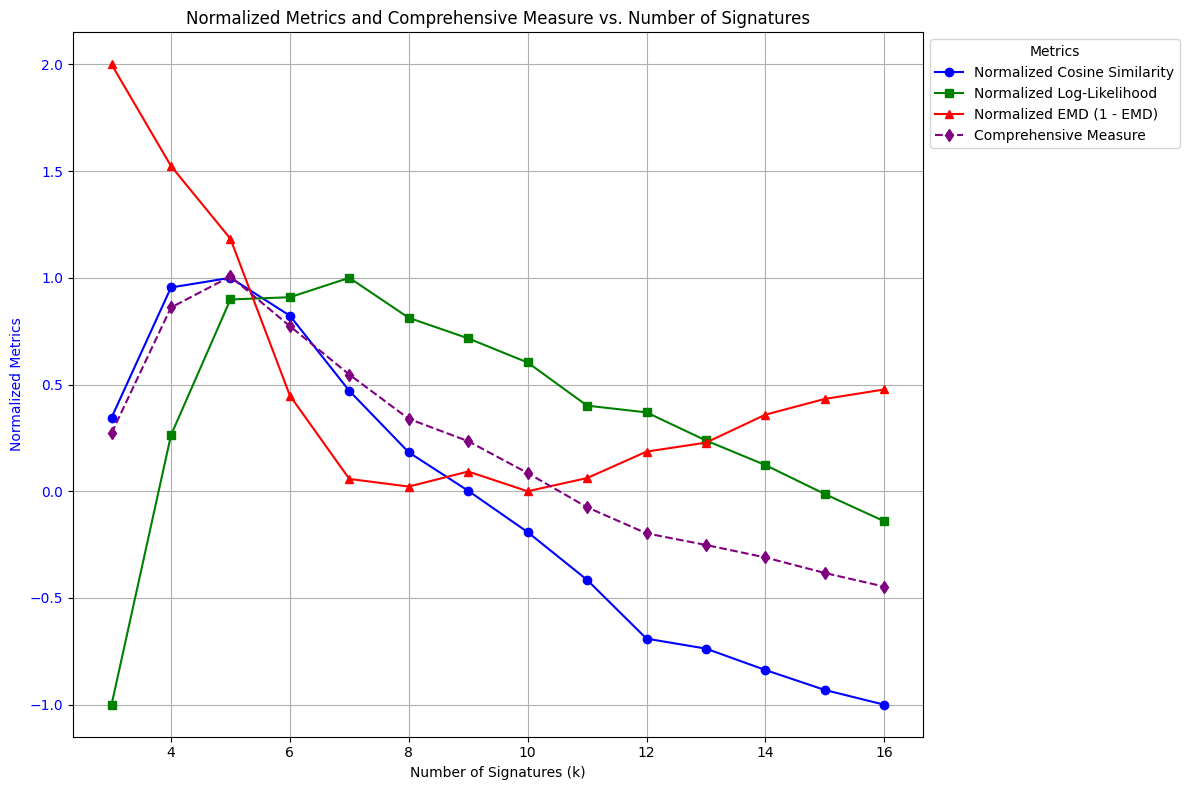

/var/folders/n7/mscr753j2cv6tdsjb7n5q4kr0000gn/T/ipykernel_49915/1448134245.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')


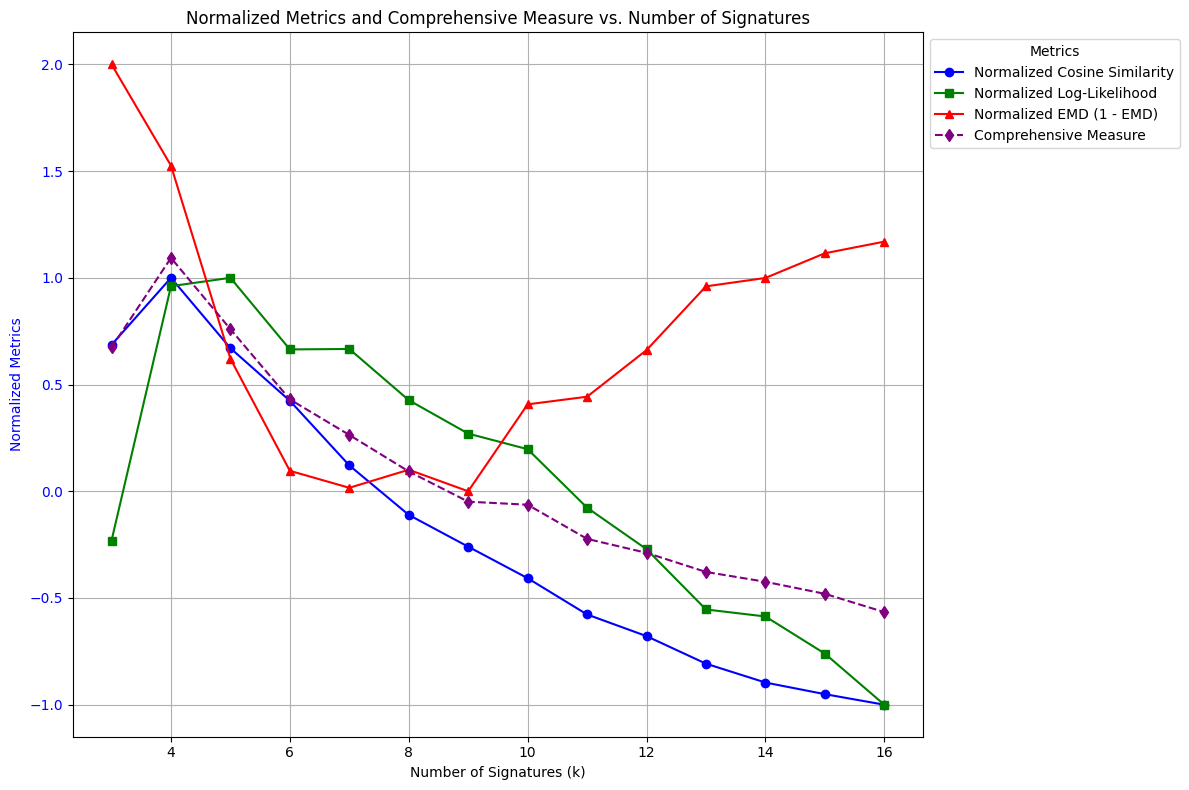

/var/folders/n7/mscr753j2cv6tdsjb7n5q4kr0000gn/T/ipykernel_49915/1448134245.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')


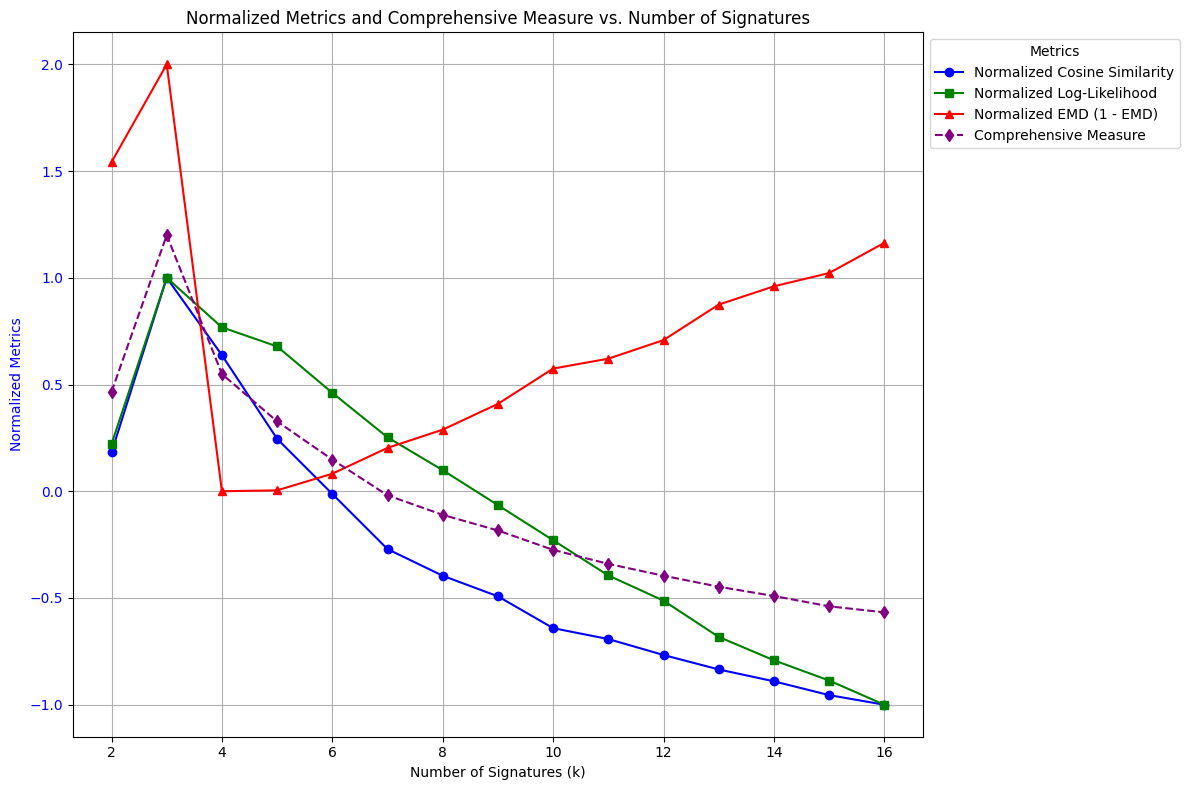

/var/folders/n7/mscr753j2cv6tdsjb7n5q4kr0000gn/T/ipykernel_49915/1448134245.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')


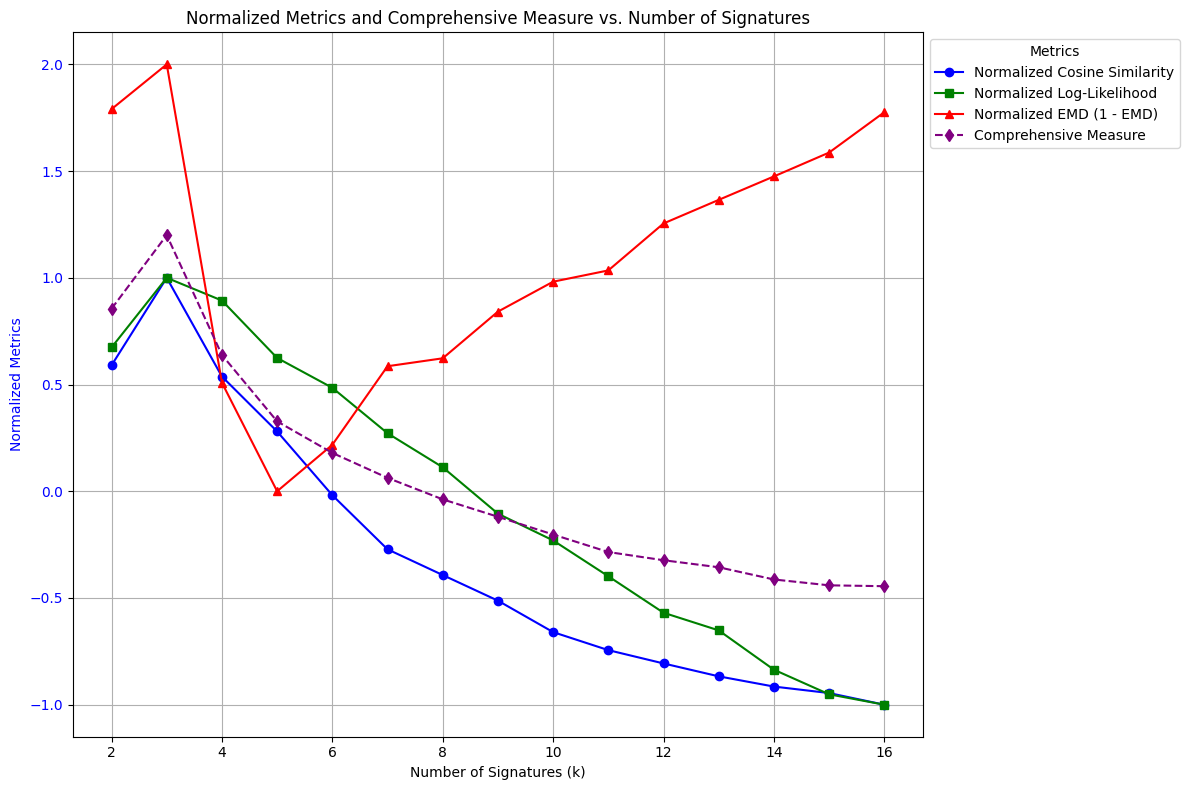

/var/folders/n7/mscr753j2cv6tdsjb7n5q4kr0000gn/T/ipykernel_49915/1448134245.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(ks, comprehensive_measure, 'd-', color='purple', label='Comprehensive Measure', linestyle='--')


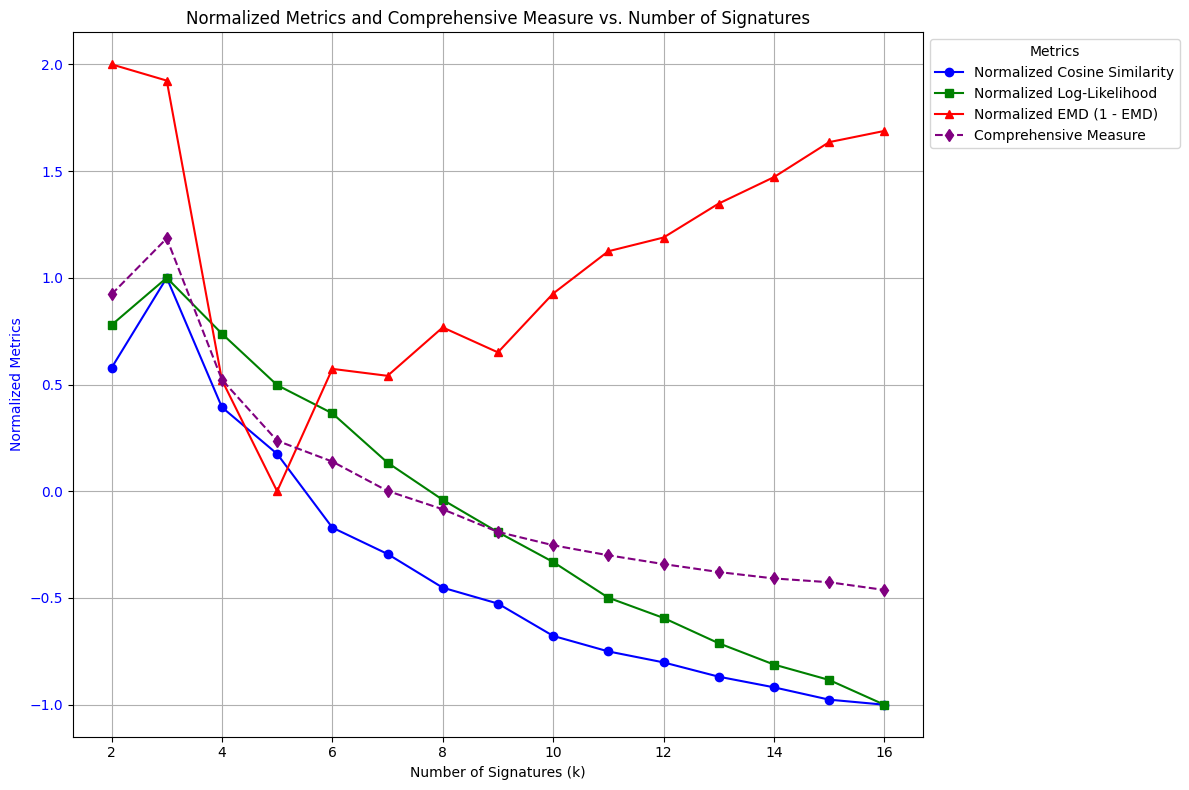

In [25]:
# Run the analysis
for i in range(1, 6):
    M_path = f'simulated_data/experiment_noise_1/data_v{i}_GRCh37_4_6_7a_9_18.csv'
    decomposed_matrices_folder = f'signature_matrices_passing_v{i}'
    perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations=300, k_values=range(2, 17), verbose=False)

In [26]:
def perform_matrix_analysis_H(M_path, decomposed_matrices_folder, iterations, k_values, verbose=True):
    """
    Analyze matrix decompositions by calculating and plotting mean cosine similarity, 
    log-likelihood, and EMD across multiple values of k (number of signatures).

    Parameters:
    ----------
    M_path : str
        Path to the input matrix M (e.g., gene expression matrix).
    decomposed_matrices_folder : str
        Folder containing the decomposed matrices (W and H).
    iterations : int
        Number of iterations for the decomposition.
    k_values : list
        Values of k (number of signatures) to analyze.
    verbose : bool
        Whether to print progress information.

    Returns:
    -------
    None
    """

    def compute_log_likelihood_poisson(M, reconstructed_M):
        return np.sum(M * np.log(reconstructed_M + 1e-10) - reconstructed_M)

    def aggregate_results(metric_list):
        """Compute mean and standard deviation for a list of metrics."""
        return np.mean(metric_list), np.std(metric_list)

    # Load and normalize input matrix M
    M = pd.read_csv(M_path).iloc[:, 1:].values.astype(float)
    M /= M.sum(axis=0, keepdims=True)

    # Initialize result dictionaries
    metrics = {"cosine": {}, "emd": {}, "log_likelihood": {}}

    for k in k_values:
        if verbose:
            print(f"Analyzing k={k}...")

        cosine_sim, emd_vals, log_likelihood_vals = [], [], []

        for rep in range(1, iterations + 1):
            W_path = f"{decomposed_matrices_folder}/D_k{k}_run{rep}.csv"
            H_path = f"{decomposed_matrices_folder}/lambda_k{k}_run{rep}.csv"

            if not os.path.exists(W_path) or not os.path.exists(H_path):
                continue

            # Load and normalize W
            W = pd.read_csv(W_path, header=None).values
            W /= W.sum(axis=1, keepdims=True)

            # Load H
            H = pd.read_csv(H_path, header=None).values

            # Reconstruct M and compute metrics
            reconstructed_M = np.dot(W, H)
            log_likelihood_vals.append(compute_log_likelihood_poisson(M, reconstructed_M))
            cosine_sim.append(np.mean(cosine_similarity(H.T)))
            emd_vals.append(np.mean([wasserstein_distance(H[i], H[j]) for i in range(H.shape[0]) for j in range(H.shape[0])]))

        # Store results (mean and std) for each k
        metrics["cosine"][k] = aggregate_results(cosine_sim)
        metrics["emd"][k] = aggregate_results(emd_vals)
        metrics["log_likelihood"][k] = aggregate_results(log_likelihood_vals)

    # Plot results
    plot_metrics(metrics, k_values)


def plot_metrics(metrics, k_values):
    """
    Plot mean cosine similarity, log-likelihood, and EMD with standard deviations.

    Parameters:
    ----------
    metrics : dict
        Dictionary containing mean and standard deviation for each metric.
    k_values : list
        Values of k to plot.

    Returns:
    -------
    None
    """
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Extract values and errors
    cosine_means = [metrics["cosine"][k][0] for k in k_values]
    cosine_stds = [metrics["cosine"][k][1] for k in k_values]
    log_means = [metrics["log_likelihood"][k][0] for k in k_values]
    log_stds = [metrics["log_likelihood"][k][1] for k in k_values]
    emd_means = [metrics["emd"][k][0] for k in k_values]
    emd_stds = [metrics["emd"][k][1] for k in k_values]

    # Plot Cosine Similarity
    ax1.errorbar(k_values, cosine_means, yerr=cosine_stds, fmt='o-', color='blue', label='Mean Cosine Similarity')
    ax1.set_xlabel('Number of Signatures (k)')
    ax1.set_ylabel('Mean Cosine Similarity', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot Log-Likelihood on secondary axis
    ax2 = ax1.twinx()
    ax2.errorbar(k_values, log_means, yerr=log_stds, fmt='s-', color='green', label='Mean Log-Likelihood')
    ax2.set_ylabel('Mean Log-Likelihood', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Plot EMD on third axis
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.errorbar(k_values, emd_means, yerr=emd_stds, fmt='^-', color='red', label='Mean EMD')
    ax3.set_ylabel('Mean EMD', color='red')
    ax3.tick_params(axis='y', labelcolor='red')

    # Add grid and title
    ax1.grid(True)
    plt.title('Metrics vs. Number of Signatures (k)')

    # Add combined legend
    lines, labels = [], []
    for ax in [ax1, ax2, ax3]:
        line, label = ax.get_legend_handles_labels()
        lines += line
        labels += label
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    plt.tight_layout()
    plt.show()

In [27]:
# Run the analysis
for i in range(1, 6):
    M_path = f'simulated_data/experiment_noise_1/data_v{i}_GRCh37_4_6_7a_9_18.csv'
    decomposed_matrices_folder = f'signature_matrices_passing_v{i}'
    perform_matrix_analysis_combined_plot_H(M_path, decomposed_matrices_folder, iterations=300, k_values=range(2, 17), verbose=False)

NameError: name 'perform_matrix_analysis_combined_plot_H' is not defined